# United States Case Law Test

# Import & cleanse data

In [1]:
import chardet
from casewrangler import CaseWrangler

import os, sys, pickle
import pandas as pd
import numpy as np

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

import datetime
from nltk.tokenize import sent_tokenize, word_tokenize

cw = CaseWrangler()

In [2]:
IllPath = os.path.abspath('Illinois-20181204-xml/data/data.jsonl.xz')
IllCases = cw.extractCases(IllPath)
IllDF = cw.wrangleCases(IllCases)

Number of Cases: 183149


In [43]:
display(IllDF.head(3))

,author,citation,court,date,jurisdiction,name,text,type,year
0,PRESIDING JUSTICE McDADE,338 Ill. App. 3d 1070,Illinois Appellate Court,2003-05-02,Illinois,Ratliff-El v. Briley,delivered the opinion of the court: Michael Ra...,majority,2003
1,JUSTICE MAAG,338 Ill. App. 3d 745,Illinois Appellate Court,2003-05-01,Illinois,Adams v. Harrah’s Maryland Heights Corp.,delivered the opinion of the court: The plaint...,majority,2003
2,PRESIDING JUSTICE HOPKINS,338 Ill. App. 3d 720,Illinois Appellate Court,2003-04-25,Illinois,In re Marriage of Bowlby,delivered the opinion of the court: The petiti...,majority,2003


In [4]:
IllDF['year'] = pd.to_datetime(IllDF['date']).apply(lambda x: x.year)

# Defining the scope of data

In [5]:
print('Ill date range:', IllDF['date'].min(), IllDF['date'].max())

Ill date range: 1771-10-12 2011-05-20


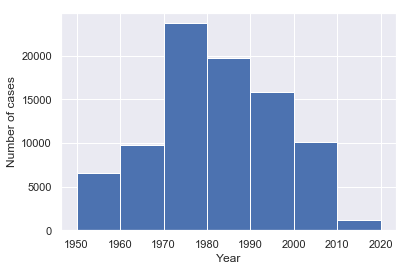

In [6]:
plt.hist(IllDF['year'],bins=[n for n in range(1950, 2030, 10)])
plt.xlabel('Year')
plt.ylabel('Number of cases')
plt.show()

In [7]:
#work on 1951-2010
IllDF = IllDF[(IllDF['year']>1950) & (IllDF['year']<=2010)]
print('Remaining number of cases:', len(IllDF))

Remaining number of cases: 85855


In [8]:
# Check the type of case
print('Illinois:\n', IllDF['type'].value_counts())

Illinois:
 majority                                     77794
dissent                                       5338
concurrence                                   1607
concurring-in-part-and-dissenting-in-part      756
rehearing                                      360
Name: type, dtype: int64


In [9]:
#work on majority type cases only
IllDF = IllDF[(IllDF['type']=='majority')]
print('Remaining number of cases:', len(IllDF))

Remaining number of cases: 77794


In [10]:
#create one dataframe
CaseLaw_DF = IllDF.drop(columns = 'type')
print('number of cases:', len(CaseLaw_DF))

number of cases: 77794


In [11]:
CaseLaw_DF = CaseLaw_DF.reset_index().drop(columns = ['index','date'])
display(CaseLaw_DF.head(3))

,author,citation,court,jurisdiction,name,text,year
0,PRESIDING JUSTICE McDADE,338 Ill. App. 3d 1070,Illinois Appellate Court,Illinois,Ratliff-El v. Briley,delivered the opinion of the court: Michael Ra...,2003
1,JUSTICE MAAG,338 Ill. App. 3d 745,Illinois Appellate Court,Illinois,Adams v. Harrah’s Maryland Heights Corp.,delivered the opinion of the court: The plaint...,2003
2,PRESIDING JUSTICE HOPKINS,338 Ill. App. 3d 720,Illinois Appellate Court,Illinois,In re Marriage of Bowlby,delivered the opinion of the court: The petiti...,2003


# Cleansing

In [12]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import string
from unidecode import unidecode

#we don't lowercase yet in case NLTK uses capitalisation for sentence tokenization
CaseLaw_DF['text_cleansed'] = CaseLaw_DF['text'].apply(lambda x: unidecode(re.sub(' +', ' ', x).strip())) #any additional whitespaces and foreign characters
CaseLaw_DF['text_cleansed'] = CaseLaw_DF['text_cleansed'].apply(lambda x: re.sub('[0-9]{1,2} [Uu]\.[Ss]\.[Cc]\. §\s?\d+(\w+)?( \([0-9]{4}\))?',' USCCITATION ',x))
CaseLaw_DF['text_cleansed'] = CaseLaw_DF['text_cleansed'].apply(lambda x: re.sub('[a-zA-Z]+ [vV]\. [a-zA-Z]+',' CaseAvCaseB ',x)) #CaseA v. CaseB = CaseAvCaseB
CaseLaw_DF['text_cleansed'] = CaseLaw_DF['text_cleansed'].apply(lambda x: re.sub('\d+ (Ark|Ill)\. \d+',' StateCase ',x))  #300 Ark. 230 = 300Ark230
CaseLaw_DF['text_cleansed'] = CaseLaw_DF['text_cleansed'].apply(lambda x: re.sub(' [Ss][Tt][Aa][Tt][Ss]\.',' stats ',x))  #300 Ark. 230 = 300Ark230
CaseLaw_DF['text_cleansed'] = CaseLaw_DF['text_cleansed'].apply(lambda x: re.sub('\d+ [A-z]+\.[ ]*[A-z]+\.[ ]*\d[A-z]+ \d+',' CaseRef ',x)) #953 S.W.2d 559 or 87 L.Ed.2d 481
CaseLaw_DF['text_cleansed'] = CaseLaw_DF['text_cleansed'].apply(lambda x: x.replace(' U.S. ','US'))
CaseLaw_DF['text_cleansed'] = CaseLaw_DF['text_cleansed'].apply(lambda x: x.replace(' S.Ct. ','SCt'))
CaseLaw_DF['text_cleansed'] = CaseLaw_DF['text_cleansed'].apply(lambda x: re.sub('[Jj][Rr]\.', 'Jr ', x))
CaseLaw_DF['text_cleansed'] = CaseLaw_DF['text_cleansed'].apply(lambda x: x.replace(' f. supp. ', ' fsupp '))
CaseLaw_DF['text_cleansed'] = CaseLaw_DF['text_cleansed'].apply(lambda x: x.replace(' cir.', ' cir '))
CaseLaw_DF['text_cleansed'] = CaseLaw_DF['text_cleansed'].apply(lambda x: re.sub('\d+ (Ark|Ill)\. App. \d+',' StateAppCase ',x))
CaseLaw_DF['text_cleansed'] = CaseLaw_DF['text_cleansed'].apply(lambda x: re.sub('(Ark|Ill)\. Code Ann\. § ',' StateCodeSection ',x))
CaseLaw_DF['text_cleansed'] = CaseLaw_DF['text_cleansed'].apply(lambda x: re.sub(' [Ii][Dd]\.',' Idem ',x))
CaseLaw_DF['text_cleansed'] = CaseLaw_DF['text_cleansed'].apply(lambda x: re.sub('§+',' Section ',x))
CaseLaw_DF['text_cleansed'] = CaseLaw_DF['text_cleansed'].apply(lambda x: re.sub('[Aa][Nn][Nn][Oo][:.]* \d+ [Aa]\.*[ ]*[Ll]\.*[ ]*[Rr]\.*[ ]*\d+','anno',x))
CaseLaw_DF['text_cleansed'] = CaseLaw_DF['text_cleansed'].apply(lambda x: re.sub(' [Aa][Nn][Nn][Oo][:.]*',' anno',x)) 
CaseLaw_DF['text_cleansed'] = CaseLaw_DF['text_cleansed'].apply(lambda x: re.sub('[Cc][Ff]\.','cf',x))
CaseLaw_DF['text_cleansed'] = CaseLaw_DF['text_cleansed'].apply(lambda x: re.sub(' [Rr][Ee][Vv]\. [Ss][Tt][Aa][Tt]\.',' revstat ',x))
CaseLaw_DF['text_cleansed'] = CaseLaw_DF['text_cleansed'].apply(lambda x: re.sub('[ \d]+[Cc][Hh]\.',' ch ',x))
CaseLaw_DF['text_cleansed'] = CaseLaw_DF['text_cleansed'].apply(lambda x: re.sub('[ \d]+[Pp][Aa][Rr]\.',' par ',x))
CaseLaw_DF['text_cleansed'] = CaseLaw_DF['text_cleansed'].apply(lambda x: re.sub('[ \d]+[Ss][Tt][Aa][Tt]\.',' stat ',x))
CaseLaw_DF['text_cleansed'] = CaseLaw_DF['text_cleansed'].apply(lambda x: x.replace('[o]', 'o')) #OCR is doing weird things: [o]ne


In [13]:
test_df = pd.DataFrame()

test_df['text'] = CaseLaw_DF['text_cleansed'].apply(lambda x: sent_tokenize(x))
test_df.reset_index(inplace=True)
rows = []
_ = test_df.apply(lambda row: [rows.append([row['index'], nn]) 
                         for nn in row['text']], axis=1)
df_new = pd.DataFrame(rows, columns=test_df.columns)
df_new = df_new.merge(CaseLaw_DF[['year']], left_on = 'index', right_index = True)
print(len(df_new)) #9,005,803

7637945


In [14]:
df_new.tail(3)

,index,text,year
7637942,77793,"We would, nevertheless, consider it appropriat...",1981
7637943,77793,The judgment is reversed and the cause remande...,1981
7637944,77793,Reversed and remanded.,1981


In [14]:
#remove punctuation only after we've tokenized the sentences
punc = string.punctuation + '—■•“’‘”|¶[]«»¿£€¥®' + string.digits
table = str.maketrans(punc, ' '*len(punc)) #replace by space
print(punc)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~—■•“’‘”|¶[]«»¿£€¥®0123456789


In [15]:
#RUN THIS
cleansed_text = []
cleansed_words = []

stop_words = stopwords.words('english')
ps = PorterStemmer() 

for row in df_new['text']:
    text = re.sub(' +', ' ',row.translate(table).strip().lower())
    
    #only keep words greater than one letter (lots of them stop words but also typos and errors from split)
    #remove stop words
    #stem the words
    words = [ps.stem(w) for w in text.split() if (len(w)>1) and (w not in stop_words)]
    
    #without stemming
#     words = [w for w in text.split() if (len(w)>1) and (w not in stop_words)]
    
    cleansed_text.append(text)
    cleansed_words.append(words)
    
df_new['text_cleansed'] = cleansed_text
df_new['words_cleansed'] = cleansed_words

print(len(df_new))

7637945


In [16]:
df_new['n_words'] = df_new['words_cleansed'].apply(len)
df_new = df_new[df_new['n_words']>0].reset_index()
print(len(df_new))

7441701


In [17]:
#de-tokenize docs
detokenized_doc = []
for i in range(len(df_new['words_cleansed'])):
    t = ' '.join(df_new['words_cleansed'].iloc[i])
    detokenized_doc.append(t)
    
df_new['sent_detok'] = detokenized_doc

In [18]:
df_new = df_new.drop(columns='level_0').rename(columns = {'index':'text_id'})
len(df_new)

7441701

# LSA by decade timeslice with Baseline (MC)

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random 

In [20]:
import math

def roundup(x):
    return int(math.ceil(x / 10.0)) * 10

t_slice = []

for y in df_new['year']:
    t = roundup(y) #e.g. 1960: 1951-1960
    t_slice.append(t)
    
df_new['t_slice'] = t_slice

In [25]:
#START AGAIN HERE AND WRITE UP ACTIONS FROM YIN
df = pd.DataFrame()
# dict_models = {}

In [24]:
#loop through each time slice to train LSA
# for t in b:
print('LSA starting')

for t in [2010]:#[1960,1970,1980,1990,2000,2010]:
    cosine_slice = [np.nan]
    MC_cosine = [np.nan]
    df_slice = df_new[df_new['t_slice']==t]
    
    # remove words that only occur 0.1% of the time in a timeslice (0.01)
    # add bigrams
    vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=200) 
    X_slice = vectorizer.fit_transform(df_slice['sent_detok'])
#     comp = vectorizer.idf_.shape[0]-1
    
    svd_model_slice = TruncatedSVD(n_components=200) #show comparison points? eyeballing topic terms
    matrix = svd_model_slice.fit_transform(X_slice)
    
    for n in range(len(matrix)-1):
        if df_slice['text_id'].iloc[n] != df_slice['text_id'].iloc[n+1]:
            cosine_slice.append(np.nan)

            #also restart MC_cosine to keep the same document lengths
            MC_cosine.append(np.nan)

        else:
            cosine_slice.append(cosine_similarity(matrix[n].reshape(1, -1),matrix[n+1].reshape(1, -1))[0][0])

            #create the cosine_similarities between random rows of the matrix rather than adjoining sentences
            rand_n1 = random.randrange(0,len(matrix))
            rand_n2 = random.randrange(0,len(matrix))
            MC_cosine.append(cosine_similarity(matrix[rand_n1].reshape(1,-1),matrix[rand_n2].reshape(1,-1))[0][0])



#     dict_models[t] = [svd_model_slice,matrix]

    df_slice['cosine_slice'] = cosine_slice
    df_slice['MC_cosine'] = MC_cosine
    df_exp = df_slice.drop(columns=['text','text_cleansed','words_cleansed','n_words','sent_detok'])
    df_exp.to_csv('df_%s.csv'%t)
    
    df = df.append(df_slice)
    
    print('finished:',t)

LSA starting


/Users/jlhc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jlhc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


finished: 2010


In [86]:
len(df) # 7441701

2420563

# Evaluating model performance

In [149]:
STOPPED HERE. WE CAN EVALUATE PERFORMANCE FOR EACH SLICE AFTERWARDS

In [40]:
dict_models.keys()

dict_keys([1960, 1970, 1980, 1990, 2000, 2010])

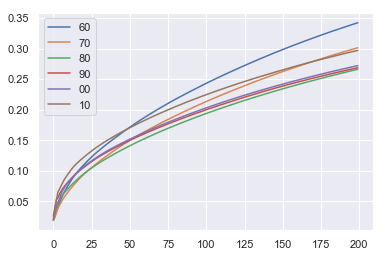

In [35]:
# for last decade
plt.plot(dict_models[1960][0].explained_variance_ratio_.cumsum(),label = '60')
plt.plot(dict_models[1970][0].explained_variance_ratio_.cumsum(),label = '70')
plt.plot(dict_models[1980][0].explained_variance_ratio_.cumsum(),label = '80')
plt.plot(dict_models[1990][0].explained_variance_ratio_.cumsum(),label = '90')
plt.plot(dict_models[2000][0].explained_variance_ratio_.cumsum(),label = '00')
plt.plot(dict_models[2010][0].explained_variance_ratio_.cumsum(),label = '10')
plt.legend()
plt.savefig('figs/var.png')
plt.show()

In [59]:
#glimpse into topics models

terms = vectorizer.get_feature_names()

print('Showing top 5 terms in each topic for the top 10 topics each decade')

for k in dict_models.keys():
    print('Decade',k)
    for i, comp in enumerate(dict_models[k][0].components_[:10]):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
        t = []
        for st in sorted_terms[:5]:
            t.append(st[0])
        print("Topic "+str(i+1)+": ",t)
    
#ss means secretarial standards

Showing top 5 terms in each topic for the top 10 topics each decade
Decade 1960
Topic 1:  ['also contend', 'defend knowledg', 'also includ', 'defend lack', 'anyth']
Topic 2:  ['arrest defend', 'await', 'counti board', 'along', 'closet']
Topic 3:  ['chester', 'amend unit', 'dawn', 'chicago illinoi', 'day care']
Topic 4:  ['convert', 'bargain agreement', 'convey', 'bargain', 'arrest defend']
Topic 5:  ['corp statecas', 'defend knowledg', 'defend held', 'decis find', 'also includ']
Topic 6:  ['acr', 'closet', 'closur', 'date august', 'automobil accid']
Topic 7:  ['bureau', 'burden show', 'crimin justic', 'counsel', 'council']
Topic 8:  ['also contend', 'defend juri', 'also held', 'anyth', 'also order']
Topic 9:  ['acr', 'court recent', 'convict', 'court recogn', 'convert']
Topic 10:  ['anyth', 'defend knowledg', 'decis find', 'appar', 'along']
Decade 1970
Topic 1:  ['apprais', 'court indic', 'approach', 'depart state', 'court interpret']
Topic 2:  ['bona fide', 'case file', 'date may', 'a

# trend analysis

In [31]:
#import scores
df_scores = pd.DataFrame()

for year in range(1960, 2020, 10):
    print(year)
    df_scores = df_scores.append(pd.read_csv('df_%s.csv'%year))

1960
1970
1980
1990
2000
2010


In [33]:
df_scores = df_scores.drop(columns='Unnamed: 0')

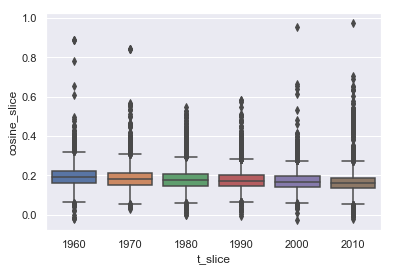

In [35]:
from statistics import mean
ave_cosine = df_scores.groupby('text_id').mean()[['cosine_slice','t_slice','year']]
ax = sns.boxplot(x='t_slice', y="cosine_slice", data=ave_cosine)

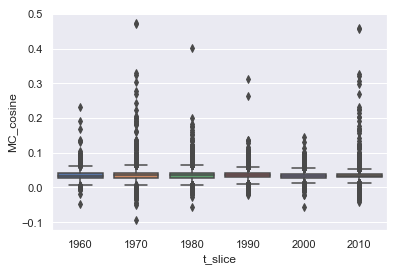

In [36]:
ave_MC = df_scores.groupby('text_id').mean()[['MC_cosine','t_slice','year']]
ax = sns.boxplot(x='t_slice', y="MC_cosine", data=ave_MC)
# plt.legend()
# plt.savefig('figure/boxplot.png')
# plt.show()

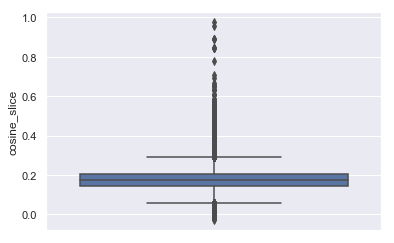

In [37]:
ax = sns.boxplot(y="cosine_slice", data=ave_cosine)
plt.savefig('figs/boxplot.png')
plt.show()

In [45]:
#outliers???
ave_cosine[ave_cosine['cosine_slice']>0.8]

,cosine_slice,t_slice,year
text_id,,,
7091,0.955970,2000.0,2000.0
9588,0.827774,1970.0,1969.0
58428,0.900509,1960.0,1958.0
60085,0.827774,1970.0,1961.0
60401,0.827774,1970.0,1964.0
62253,0.827774,1970.0,1965.0
75303,0.900509,1960.0,1960.0
75439,0.900509,1960.0,1960.0
76695,0.973960,2010.0,2004.0


In [61]:
df[df['text_id']==7091]['text']

1009377    Orders of the Court: The motion by Claudia Day...
1009378    The motion by Robert L. Kramer to strike his n...
Name: text, dtype: object

In [62]:
#max
df[df['text_id']==9588]['text']

1248710    Opinion by Not to be published in.
1248711                                 full.
Name: text, dtype: object

In [66]:
#outliers???
ave_cosine[ave_cosine['cosine_slice']<0].sort_values('cosine_slice')

,cosine_slice,t_slice,year
text_id,,,
7078,-0.026921,2000.0,2000.0
58181,-0.021270,1960.0,1957.0
57141,-0.017626,1960.0,1955.0
57857,-0.017626,1960.0,1957.0
57893,-0.017626,1960.0,1957.0
58065,-0.017626,1960.0,1957.0
57891,-0.015646,1960.0,1957.0
7053,-0.013576,2010.0,2002.0
74677,-0.009542,2010.0,2006.0


In [67]:
df[df['text_id']==7078]

,index2,text_id,text,year,text_cleansed,words_cleansed,n_words,sent_detok,t_slice,cosine_slice
1008808,1030760,7078,Order of the Court: The petition by the Admini...,2000,order of the court the petition by the adminis...,"[order, court, petit, administr, attorney, reg...",16,order court petit administr attorney registr d...,2000,NaN
1008809,1030761,7078,Respondent Maureen F.X.,2000,respondent maureen f x,"[respond, maureen]",2,respond maureen,2000,0.001385
1008810,1030762,7078,Walsh is disbarred.,2000,walsh is disbarred,"[walsh, disbar]",2,walsh disbar,2000,-0.055227


In [68]:
df[df['text_id']==58181]

,index2,text_id,text,year,text_cleansed,words_cleansed,n_words,sent_detok,t_slice,cosine_slice
5780094,5928330,58181,delivered the opinion of the court.,1957,delivered the opinion of the court,"[deliv, opinion, court]",3,deliv opinion court,1960,NaN
5780095,5928331,58181,Not to be pub- lished in full.,1957,not to be pub lished in full,"[pub, lish, full]",3,pub lish full,1960,-0.02127


/Users/jlhc/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


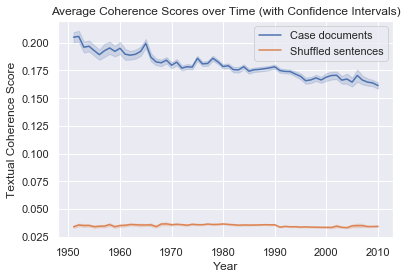

In [46]:
ax = sns.lineplot(x='year', y="cosine_slice", data=ave_cosine,label='Case documents')
ax = sns.lineplot(x='year', y="MC_cosine", data=ave_MC,label='Shuffled sentences')
plt.xlabel('Year')
plt.ylabel('Textual Coherence Score')
plt.title('Average Coherence Scores over Time (with Confidence Intervals)')
plt.savefig('figs/coherence.png')
plt.show()

In [40]:
#average of average
ave_cosine_t = ave_cosine.groupby('year').mean()['cosine_slice']
ave_MC_t = ave_MC.groupby('year').mean()['MC_cosine']

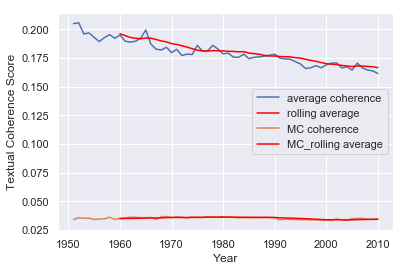

In [42]:
moving_avg = ave_cosine_t.rolling(10).mean()
moving_avg_MC = ave_MC_t.rolling(10).mean()

plt.plot(ave_cosine_t, label = 'average coherence')
plt.plot(moving_avg, color='red', label = 'rolling average')
plt.plot(ave_MC_t, label = 'MC coherence')
plt.plot(moving_avg_MC, color='red', label = 'MC_rolling average')
plt.xlabel('Year')
plt.ylabel('Textual Coherence Score')
plt.legend()
plt.savefig('figs/rolling.png')
plt.show()

In [70]:
moving_avg

year
1951.0         NaN
1952.0         NaN
1953.0         NaN
1954.0         NaN
1955.0         NaN
1956.0         NaN
1957.0         NaN
1958.0         NaN
1959.0         NaN
1960.0    0.196079
1961.0    0.194495
1962.0    0.192734
1963.0    0.192049
1964.0    0.191397
1965.0    0.191988
1966.0    0.191473
1967.0    0.190272
1968.0    0.188673
1969.0    0.187660
1970.0    0.185920
1971.0    0.185222
1972.0    0.184161
1973.0    0.183119
1974.0    0.181879
1975.0    0.180588
1976.0    0.180290
1977.0    0.180364
1978.0    0.181020
1979.0    0.181116
1980.0    0.181190
1981.0    0.180911
1982.0    0.180760
1983.0    0.180491
1984.0    0.180562
1985.0    0.179422
1986.0    0.178883
1987.0    0.178352
1988.0    0.177418
1989.0    0.176870
1990.0    0.176843
1991.0    0.176397
1992.0    0.176247
1993.0    0.176088
1994.0    0.175407
1995.0    0.174918
1996.0    0.173922
1997.0    0.172956
1998.0    0.172134
1999.0    0.171036
2000.0    0.170070
2001.0    0.169386
2002.0    0.168876
2003.0 